In [1]:
import cv2
import os
import numpy as np
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
from kstlib.image import imregionalmin, imregionalmax, show_image

In [15]:
# read image paths
dolphin_dir = "data/dolphin"
dolphin_path = [
    os.path.join(dolphin_dir, filename)
    for filename in os.listdir(dolphin_dir)
    if os.path.isfile(os.path.join(dolphin_dir, filename))
]
# convert to floating points
dolphin_imgs = np.array(
    [
        cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2GRAY) / 255.0
        for filename in dolphin_path
    ]
)

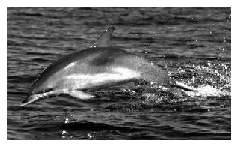

In [16]:
img = dolphin_imgs[11]
show_image(img)

In [17]:
# Parameters
# number of scales
s = 3
# assumed smoothing
init_sigma = 0.5
# initial smoothing
sigma = 1.6

In [18]:
def gen_gaussian_pyr(image, octaves=None, scales=3, dbl_size=True):
    """
    Generate gaussian pyramid
    
    Parameters:
    - image: grayscale image from last octave
    - octaves: number of octaves
    - scales: number of scales
    - dbl_size: if size should be doubled
    Returns:
    - octave * (scale+3) guassian pyramid
    """
    # scaling factor of sigma
    k = 2 ** (1.0 / scales)
    # sigma for each scale
    sig = np.zeros((scales + 3))
    sig[0] = sigma
    sig[1] = sigma * np.sqrt(k ** 2 - 1)
    
    if dbl_size:
        image = cv2.resize(image, dsize=(0,0), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    for i in range(2, scales + 3):
        sig[i] = sig[i - 1] * k

    if octaves == None:
        octaves = int(np.log2(np.min([image.shape[0], image.shape[1]])) - 2)

    # construct pyramid
    pyramid = []
    curr_x, curr_y = image.shape
    for o in range(octaves):
        pyr_octave = []
        for i in range(0, scales + 3):
            if o == 0 and i == 0:
                if dbl_size:
                    pyr_octave.append(ndi.gaussian_filter(image, sigma=sigma ** 2 - (init_sigma ** 2)*4))
                else:
                    pyr_octave.append(ndi.gaussian_filter(image, sigma=sigma ** 2 - init_sigma ** 2))
            elif o != 0 and i == 0:
                pyr_octave.append(pyramid[o - 1][scales][::2, ::2])
            else:
                pyr_octave.append(ndi.gaussian_filter(pyr_octave[i - 1], sigma=sig[i]))
        pyramid.append(pyr_octave)
    return pyramid

In [19]:
def gen_DoG(gaussian_pyr):
    """
    Generate DoG image for octave.
    
    Parameters:
    - gaussian_pyr
    Returns:
    - octaves * (scales+2) DoG images
    """
    dog_pyr = []
    for o in range(len(gaussian_pyr)):
        n = len(gaussian_pyr[0]) - 1
        # s+2
        dog_octave = np.zeros(
            (n, gaussian_pyr[o][0].shape[0], gaussian_pyr[o][0].shape[1])
        )
        for i in range(0, n):
            dog_octave[i] = gaussian_pyr[o][i + 1] - gaussian_pyr[o][i]
        dog_pyr.append(dog_octave)
    return dog_pyr

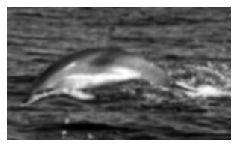

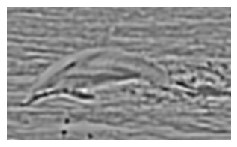

In [20]:
# gaussian pyramid
gaussian_pyramid = gen_gaussian_pyr(img)
# DoG pyramid
DoG = gen_DoG(gaussian_pyramid)
show_image(gaussian_pyramid[1][0])
show_image(DoG[1][2])

In [21]:
def get_extrema(DoG):
    S, X, Y = DoG.shape
    candidates = []
    for s in range(1, S - 1):
        for x in range(1, X - 1):
            for y in range(1, Y - 1):
                patch = DoG[s - 1 : s + 2, x - 1 : x + 2, y - 1 : y + 2]
                if np.argmax(patch) == 13 or np.argmin(patch) == 13:
                    candidates.append([s, x, y])
    return np.array(candidates)

In [22]:
nbhd = ndi.generate_binary_structure(3, 3)
features = []

for dog in DoG:
    feat_octave = []
    local_max = imregionalmax(dog, footprint=nbhd)
    local_min = imregionalmin(dog, footprint=nbhd)
    max_idx = np.argwhere(local_max[1:-1, 1:-1, 1:-1] == 1)
    min_idx = np.argwhere(local_min[1:-1, 1:-1, 1:-1] == 1)
    if max_idx.size != 0:
        max_idx = max_idx + 1
        feat_octave.extend(max_idx.tolist())
    if min_idx.size != 0:
        min_idx = min_idx + 1
        feat_octave.extend(min_idx.tolist())
    features.append(np.array(feat_octave))
print(features[0].shape)

features2 = []
feat_local = []
for o in range(len(DoG)):
    features2.append(get_extrema(DoG[o]))

print(features2[0].shape)
print(features2[0])

(1075, 3)
(1075, 3)
[[  1   4 394]
 [  1   5 231]
 [  1   5 426]
 ...
 [  3 350 420]
 [  3 351 214]
 [  3 351 532]]


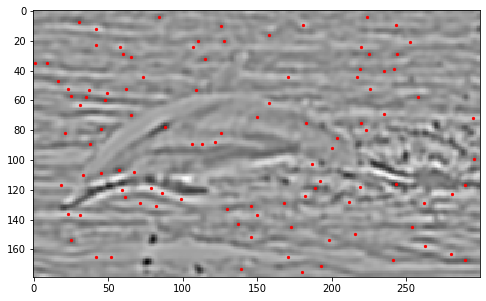

(220, 3)
(220, 3)


In [34]:
keypt = features2[1]
keypt = keypt[keypt[:,0] == 1]
plt.figure(figsize=2.0* plt.figaspect(1))
plt.imshow(DoG[1][1], interpolation='nearest')
plt.scatter(keypt[:,2], keypt[:,1], s=5, c='r')
plt.show()

print(features[1].shape)
print(features2[1].shape)

In [11]:
x,y = 183,598

print(imregionalmin(DoG[0][:,x-1:x+2,y-1:y+2], footprint=nbhd)[1:-1])
print(DoG[0][:,x-1:x+2,y-1:y+2])

[[[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[-0.00208662 -0.00207535 -0.00206396]
  [-0.00250164 -0.00252168 -0.00252964]
  [-0.00205845 -0.00203652 -0.00201616]]

 [[-0.00251766 -0.00245434 -0.0024162 ]
  [-0.00285668 -0.00284717 -0.00283365]
  [-0.00233637 -0.00235222 -0.00234454]]

 [[-0.00277744 -0.00269912 -0.00265101]
  [-0.00292753 -0.00293326 -0.0029285 ]
  [-0.00237424 -0.00245628 -0.00249086]]

 [[-0.0027837  -0.0027226  -0.00268833]
  [-0.00276378 -0.00278312 -0.00279281]
  [-0.00225299 -0.00235135 -0.00240456]]

 [[-0.0027014  -0.00263727 -0.00260585]
  [-0.00255184 -0.00254011 -0.00253715]
  [-0.00210149 -0.00214455 -0.00217133]]]
